# Feedback Loop Experiments

This notebook looks at what happens in a toy example where a model has some false negative rate, and is able to influence new data coming in through its predictions. It quantifies how long it takes for the model to degenerate and completely cheat.

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

from functools import reduce
from sklearn.datasets import make_classification
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import copy

import numpy as np

## Create Initial Data

In [47]:
np.random.seed(5)
X, y = make_classification(1000000, 2, n_redundant=0, flip_y=0.0, class_sep=1.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.999)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test, y_test, test_size=0.5)

We assume some false positives labeled in the training data in order to induce an FPR > 0 in the model for the case where data is not linearly separable

In [48]:
# neg_idx = y_train == 0
# neg_idx = np.where(neg_idx)
# bernoulli = np.random.choice([0, 1], len(neg_idx), [1 - 0.1, 0.1])
# y_train[neg_idx] = bernoulli

## Train Linear Model

In [49]:
model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")

In [50]:
model.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=True)

## Visualize Model Predictions

In [51]:
x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 100), np.linspace(x2_min, x2_max, 100))

In [52]:
z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

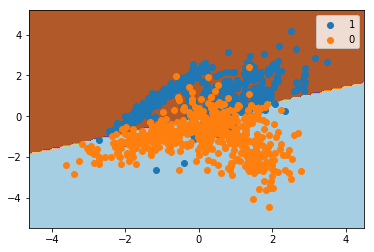

In [53]:
pos_idx = y_train[:1000] == 1
pos_idx = np.where(pos_idx)
neg_idx = y_train[:1000] == 0
neg_idx = np.where(neg_idx)

plt.contourf(xx, yy, z, cmap=plt.cm.Paired)
plt.scatter(X_train[pos_idx, 0], X_train[pos_idx, 1], label=1)
plt.scatter(X_train[neg_idx, 0], X_train[neg_idx, 1], label=0)
plt.legend()

## Quantify Test Set Performance

In [59]:
y_pred = model.predict(X_test2)

In [60]:
c_matrix = confusion_matrix(y_test2, y_pred)

In [61]:
c_matrix

array([[220080,  29733],
       [ 26056, 223631]])

In [62]:
tn, fp, fn, tp = c_matrix.ravel()

In [63]:
print("FPR: {}".format(float(fp) / float(len(y_pred))))
print("TPR: {}".format(float(tp) / float(len(y_pred))))
print("FNR: {}".format(float(fn) / float(len(y_pred))))
print("TNR: {}".format(float(tn) / float(len(y_pred))))

FPR: 0.05952552552552553
TPR: 0.4477097097097097
FNR: 0.05216416416416417
TNR: 0.4406006006006006


## Update Model On New Data - $p(y | x)$ changes

### Do Not Retrain on Original Train Set

#### Blind Trust

Let's start with the original test set. Our model has a certain false positive rate on it. However, the model predictions influence clinician decisions which in turn affects the observed label. Our original test set labels are our oracle. However, we will make it so that false positive predictions end up overwriting the labels (i.e. predicting death results in paliative care which in turn results in death)

What we want to quantify is how the number of updates affects the FPR while keeping the number of new samples the same. My guess is that more updates will result in higher FPR since the model has more opportunities to cheat. I think that some theory can be developed around this since the FPR is probably non-decreasing for each update.

In [32]:
def train_model_online(num_updates):
    np.random.seed(1)
    new_model = copy.deepcopy(model)
    
    size = float(len(y_test1)) / float(num_updates)
    
    prediction_differences = []
    
    orig_train_pred = new_model.predict(X_train)
    classes = np.unique(y_test1)

    for i in range(num_updates):
        idx_start = int(size * i)
        idx_end = int(size * (i + 1))
        sub_x = X_test1[idx_start: idx_end, :]
        sub_y = copy.deepcopy(y_test1[idx_start: idx_end])

        sub_pred = new_model.predict(sub_x)
        fp_idx = np.logical_and(sub_y == 0, sub_pred == 1)
        sub_y[fp_idx] = 1

        new_model.partial_fit(sub_x, sub_y, classes)
        
#         new_train_pred = new_model.predict(X_train)
#         prediction_differences.append(np.sum(orig_train_pred != new_train_pred))
        
    return new_model, prediction_differences

In [15]:
def eval_model(model, X, y):
    y_pred = model.predict(X)
    c_matrix = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = c_matrix.ravel()

    samples = float(len(y_pred))
    
    return tn / samples, fp / samples, fn / samples, tp / samples

In [16]:
num_updates = [1, 5, 10, 20, 40, 50, 100, 200, 300, 400, 1000, 2500]
fps = {}
prediction_differences = {}

In [17]:
for i in num_updates:
    temp_model, temp_differences = train_model_online(i)
    tn, fp, fn, tp = eval_model(temp_model, X_test2, y_test2)
    fps[i] = fp
    prediction_differences[i] = temp_differences

In [18]:
fps

{1: 0.08211411411411411,
 5: 0.15448848848848848,
 10: 0.1982882882882883,
 20: 0.27654654654654653,
 40: 0.33987387387387386,
 50: 0.38536536536536536,
 100: 0.44422022022022023,
 200: 0.5001261261261262,
 300: 0.5001261261261262,
 400: 0.5001261261261262,
 1000: 0.5001261261261262,
 2500: 0.5001261261261262}

In [ ]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("FPR Degeneration as Function of Updates", fontsize=24)

ax = fig.add_subplot(111)
ax.plot(list(fps.keys()), list(fps.values()))
ax.scatter(list(fps.keys()), list(fps.values()))
ax.set_xlabel("Num Updates", fontsize=20)
ax.set_ylabel("FPR", fontsize=20)
fig.show()

In [ ]:
len(y_test1)

In [ ]:
fig = plt.figure()
fig.suptitle("Pred Differences")

ax = fig.add_subplot(111)

for idx, i in enumerate(prediction_differences.keys()):
    samples = len(prediction_differences[i])
    x = np.arange(1, samples + 1)
    ax.plot(x, prediction_differences[i], c=plt.get_cmap("Paired").colors[idx], label=str(i))
    
ax.legend()
fig.show()

#### Partial Trust

Now we consider the case where our physician's trust in the system varies. To do so, we need a model of our physician's decisions. Since we know the ground truth (oracle) because we generate the data, we can define the physician model via some FPR, FNR, TPR, TNR rates where intentional mistakes are sampled. 

We know that physicians and ML models make "different" kinds of mistakes, so perhaps we do something like (proportional to) swapping the FPR and FNR of the ML model

In [33]:
def train_model_online_partial_trust(num_updates, trust):
    np.random.seed(1)
    new_model = copy.deepcopy(model)
    
    size = float(len(y_test1)) / float(num_updates)
    
    prediction_differences = []
    
    orig_train_pred = new_model.predict(X_train)
    classes = np.unique(y_test1)

    for i in range(num_updates):
        idx_start = int(size * i)
        idx_end = int(size * (i + 1))
        sub_x = X_test1[idx_start: idx_end, :]
        sub_y = copy.deepcopy(y_test1[idx_start: idx_end])

        sub_pred = new_model.predict(sub_x)
        bernoulli = np.random.choice([False, True], size=len(sub_y), p=[1 - trust, trust])

        fp_idx = bernoulli * np.logical_and(sub_y == 0, sub_pred == 1)
        sub_y[fp_idx] = 1

        new_model.partial_fit(sub_x, sub_y, classes)
        
#         new_train_pred = new_model.predict(X_train)
#         prediction_differences.append(np.sum(orig_train_pred != new_train_pred))        
    return new_model, prediction_differences

In [34]:
temp_model, temp_differences = train_model_online_partial_trust(1, 1.0)
tn, fp, fn, tp = eval_model(temp_model, X_test2, y_test2)
print(fp)

0.08264864864864865


In [35]:
trust = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
num_updates = [1, 5, 10, 20, 40, 50, 100, 200, 300, 400, 1000, 2500]
fps = {i: {} for i in trust}
prediction_differences = {i: {} for i in trust}

In [36]:
for i in trust:
    for k in num_updates:
        temp_model, temp_differences = train_model_online_partial_trust(k, i)
        tn, fp, fn, tp = eval_model(temp_model, X_test2, y_test2)
        fps[i][k] = fp
        prediction_differences[i][k] = temp_differences

In [ ]:
fps

In [ ]:
%matplotlib inline

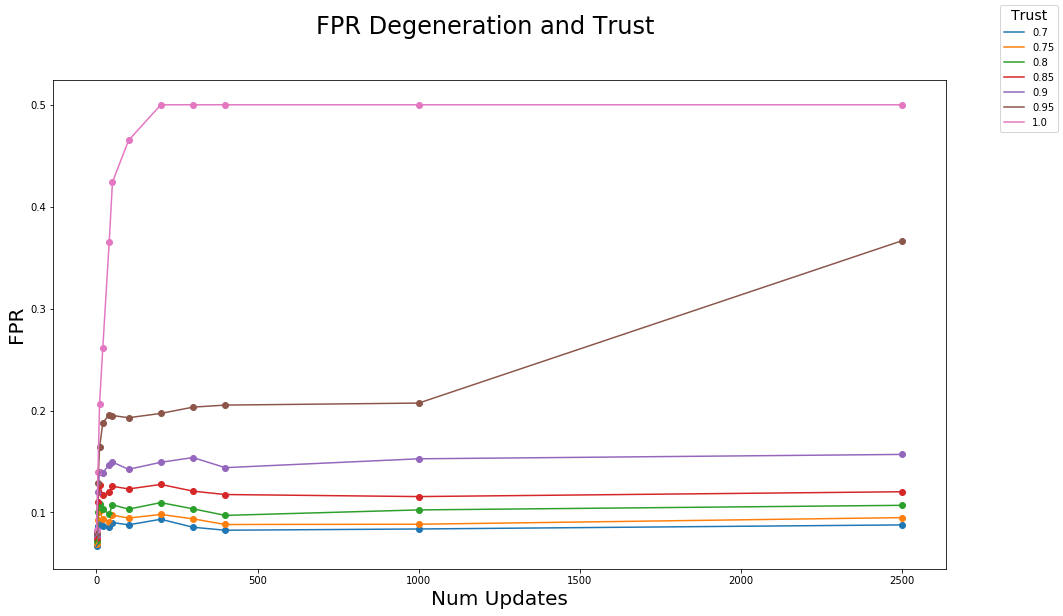

In [37]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("FPR Degeneration and Trust", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("FPR", fontsize=20)
ax.set_xlabel("Num Updates", fontsize=20)

for count, i in enumerate(trust):
    ax.plot(list(fps[i].keys()), list(fps[i].values()), label=str(i))
    ax.scatter(list(fps[i].keys()), list(fps[i].values()))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title="Trust", title_fontsize=14)
fig.show()

In [ ]:
fps[0.1]

In [ ]:
fps[0.9]

### Keep Refitting Original Train Set

To ensure that our newly updated model does not make different predictions on the old data than the original, when updating the model, we train on both the new data and the original training set combined.

In [64]:
def train_model_online_refit(num_updates):
    np.random.seed(1)
    new_model = copy.deepcopy(model)
    
    size = float(len(y_test1)) / float(num_updates)
    prediction_differences = []
    orig_train_pred = new_model.predict(X_train)
    
    classes = np.unique(y_test1)

    for i in range(num_updates):
        idx_start = int(size * i)
        idx_end = int(size * (i + 1))
        sub_x = X_test1[idx_start: idx_end, :]
        sub_y = copy.deepcopy(y_test1[idx_start: idx_end])

        sub_pred = new_model.predict(sub_x)
        fp_idx = np.logical_and(sub_y == 0, sub_pred == 1)
        sub_y[fp_idx] = 1

        new_model.partial_fit(np.concatenate((X_train, sub_x)), np.concatenate((y_train, sub_y)), classes)
        
#         new_train_pred = new_model.predict(X_train)
#         prediction_differences.append(orig_train_pred != new_train_pred)
        
    return new_model, prediction_differences

In [65]:
num_updates = [1, 5, 10, 20, 40, 50, 100, 200, 300, 400, 1000, 2500]
fps = {}
prediction_differences = {}

In [66]:
for i in num_updates:
    temp_model, temp_differences = train_model_online_refit(i)
    tn, fp, fn, tp = eval_model(temp_model, X_test2, y_test2)
    fps[i] = fp
    prediction_differences[i] = temp_differences

In [68]:
fps

{1: 0.08358958958958959,
 5: 0.1380960960960961,
 10: 0.20306506506506505,
 20: 0.20892892892892892,
 40: 0.15734934934934935,
 50: 0.14956356356356357,
 100: 0.11367767767767768,
 200: 0.08956356356356357,
 300: 0.07878678678678679,
 400: 0.07207607607607608,
 1000: 0.059925925925925924,
 2500: 0.054954954954954956}

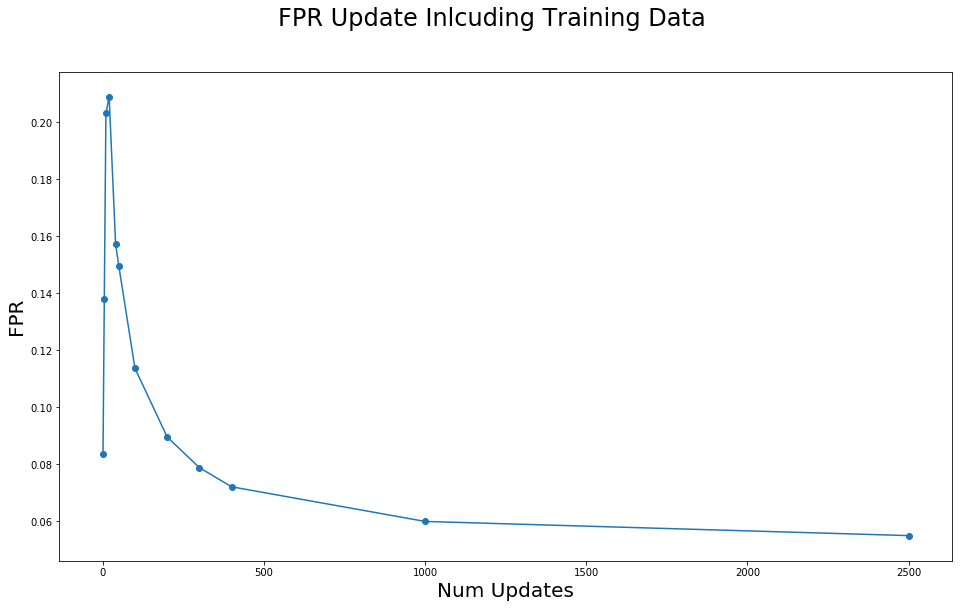

In [67]:
fig = plt.figure(figsize=(16, 9))
fig.suptitle("FPR Update Inlcuding Training Data", fontsize=24)

ax = fig.add_subplot(111)
ax.plot(list(fps.keys()), list(fps.values()))
ax.scatter(list(fps.keys()), list(fps.values()))
ax.set_xlabel("Num Updates", fontsize=20)
ax.set_ylabel("FPR", fontsize=20)

fig.show()

In [ ]:
fig = plt.figure()
fig.suptitle("Pred Differences")

ax = fig.add_subplot(111)

for idx, i in enumerate(prediction_differences.keys()):
    samples = len(prediction_differences[i])
    x = np.arange(1, samples + 1)
    ax.plot(x, prediction_differences[i], c=plt.get_cmap("Paired").colors[idx], label=str(i))
    
ax.legend()
fig.show()

Since the size of the training set is so large, the flipped labels in the test set have almost no effect because the model would have to memorize the flipped test set labels in order to both correctly predict the train set labels, and the flipped test set labels.

What we've looked at so far is a mild case of what might happen since only $p(y | x)$ changes. What if we also end up changing $p(x)$? I.e., after each model update, we also increase the probability that we see patients with a certain type of feature that is associated with being able to recover. Doing so gives a double whammy since by increasing the ratio of negative to positive samples, for a fixed FPR, we will have a greater number of false positives, and thus the model will likely deteriorate faster.

## Update Model on New Data - Both $p(y | x)$ and $p(y)$ change

Based on the change in FPR after an update, we will bias the sample of the test set at the next iteration to include proprotionally more negative samples. For the moment, the simplest way of doing this would be to simply drop some proportion of positive samples

In [ ]:
temp1 = np.arange(5)
temp2 = np.arange(5)
temp2[2] = 20

np.where(temp1 == temp2)

In [ ]:
def train_model_online_conditional_and_marginal(num_updates):
    np.random.seed(1)
    new_model = copy.deepcopy(model)
    orig_pred = new_model.predict(X_test)
    orig_fpr = np.sum(np.logical_and(y_test == 0, orig_pred == 1)) / float(len(y_test))
    
    size = float(len(y_test)) / float(num_updates)
    delta = 0

    for i in range(num_updates):
        idx_start = int(size * i)
        idx_end = int(size * (i + 1))
        sub_x = copy.deepcopy(X_test[idx_start: idx_end, :])
        sub_y = copy.deepcopy(y_test[idx_start: idx_end])
        sub_y_pert = copy.deepcopy(sub_y)
        
        if delta > 0:
            pos_idx = np.where(sub_y == 1)[0]
            rate = np.min((delta, 0.2))
            print(pos_idx.shape)
            print(np.round(rate * len(pos_idx)))
            drop = np.random.choice(pos_idx, int(rate * len(pos_idx)))
            print(len(drop))
            sub_x = np.delete(sub_x, drop, axis=0)
            sub_y = np.delete(sub_y, drop, axis=0)
            sub_y_pert = np.delete(sub_y_pert, drop, axis=0)
            
        
        sub_pred = new_model.predict(sub_x)
        fp_idx = np.logical_and(sub_y == 0, sub_pred == 1)
        sub_y_pert[fp_idx] = 1

        new_model.fit(sub_x, sub_y_pert)
        new_pred = new_model.predict(sub_x)
        new_fpr = np.sum(np.logical_and(sub_y == 0, sub_pred == 1)) / float(len(sub_y))
        
        delta += new_fpr - orig_fpr
        print(delta)
        
    return new_model

In [ ]:
num_updates = [1, 5, 10, 20, 40, 50, 100]
fps = {}
prediction_differences = {}

In [ ]:
for i in num_updates:
    temp_model = train_model_online_conditional_and_marginal(i)
    tn, fp, fn, tp = eval_model(temp_model, X_test, y_test)
    fps[i] = fp
    prediction_differences[i] = temp_differences

In [ ]:
fps